In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from keras.datasets import mnist

2022-12-11 22:29:30.346280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
DATA_DIR = 'data_mnist/'

In [ ]:
#подготоваливаем обучающие изображение, меняем их размер
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
torch.cuda.set_device(2)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

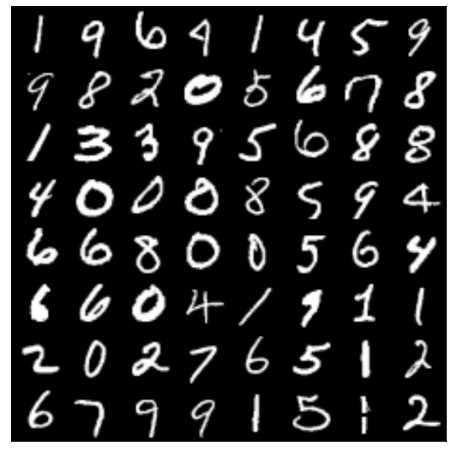

In [ ]:
show_batch(train_dl)

In [ ]:
!nvidia-smi

Sun Dec 11 23:43:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |  32285MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [ ]:
# перенос батчей на гпу
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

# DCGAN

In [ ]:
# Должен выдать вероятность принадлжености к классу
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
#вход вектор шума и и применяем обратные свёртки и гиперболический тангенс, для нормального цвета
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


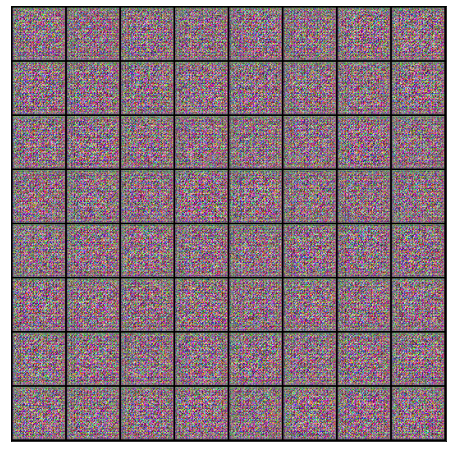

In [ ]:
 # Смотрим на гауссовский шум из нормального распределения и смотри, что с ним сделает генератор
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # потери и точность
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Задаём оптимизаторы
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Учим дискриминатор
            # Очищаем гридиент дискриминатора
            optimizer["discriminator"].zero_grad()

            # берём реальные изображения и пропускаем через дискриминатор
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Создаём фейк изображение
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Пропускаем фейк изображения и пропускаем через дискриминатор
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса дискриминатора
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Учим генератор
            # Очищаем градиент генератора
            optimizer["generator"].zero_grad()
            
            # Создаём фейк изображение
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(), #бинарная кросс энтропия 
    "generator": nn.BCELoss()
}
lr = 0.001
epochs = 10

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 2.0064, loss_d: 1.3643, real_score: 0.6194, fake_score: 0.3784


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 2.2509, loss_d: 1.0266, real_score: 0.6852, fake_score: 0.3142


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 2.6788, loss_d: 0.8904, real_score: 0.7350, fake_score: 0.2640


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.0014, loss_d: 0.7893, real_score: 0.7681, fake_score: 0.2322


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 3.1616, loss_d: 0.7285, real_score: 0.7889, fake_score: 0.2110


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.1492, loss_d: 0.7628, real_score: 0.7900, fake_score: 0.2094


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.9135, loss_d: 0.5575, real_score: 0.8473, fake_score: 0.1525


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.1726, loss_d: 0.7904, real_score: 0.7958, fake_score: 0.2025


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 3.2747, loss_d: 0.6506, real_score: 0.8223, fake_score: 0.1787


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.7777, loss_d: 0.5994, real_score: 0.8395, fake_score: 0.1595
Saving generated-images-0010.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 7,  7,  8],
        ...,
        [21, 11, 15],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [12, 13, 13],
        ...,
        [ 9,  8, 14],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

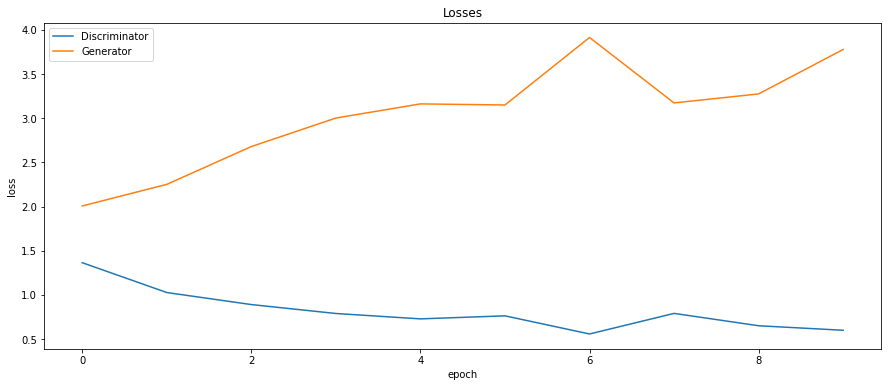

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

# VAE
Хотим выучить параметры распределения mu, sigma, нормальное распределение (среднее и стандартное отклонение)

In [ ]:
from keras.datasets import mnist
import numpy as np
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import skimage.io
#import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
DATA_DIR = 'data_mnist/'

In [ ]:
!nvidia-smi

Wed Dec 14 10:50:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   40C    P0    55W / 300W |  32285MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

In [ ]:
torch.cuda.set_device(1)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

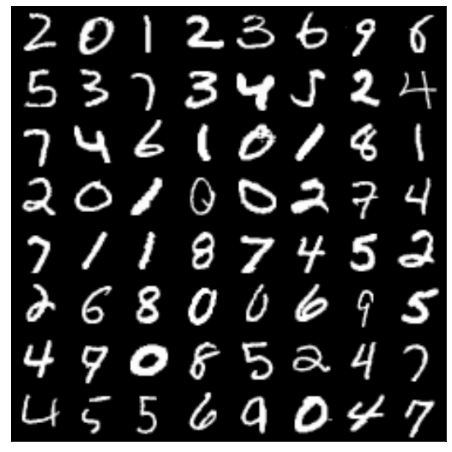

In [ ]:
show_batch(train_dl)

In [ ]:
features = 16 #размерность латентного параметра

class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        self.flatten = nn.Flatten()
 
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=features*2)

        )
 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=784)
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log dis
        
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        x = self.flatten(x).float() # плющим
        x = self.encoder(x).view(-1, 2, features) # плющим
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, log_var

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 28, 28, 1)
        return generated

    def get_latent_vector(self, x):
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        return z

Лосс состоит из двух частей:
1. KL-дивергенции, отвечающей за то, как далеко друг от друга находятся распределения, соответствующие разным объектам.
2. В качестве log-likelihood возьмем привычную нам кросс-энтропию (на сколько хорошо реконструируем изображение)
.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = LinearVAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) 
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) 
input_shape = (1, 28, 28) 


x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 
x_train /= 255 
x_test /= 255 

In [ ]:
val_loader

In [ ]:
train_loader = torch.utils.data.DataLoader(x_train, batch_size=32)
val_loader = torch.utils.data.DataLoader(x_test, batch_size=32)

In [ ]:
n_epochs = 50
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 28, 28, 1)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction, mu, logsigma = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 28, 28, 1)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
autoencoder.eval()
with torch.no_grad():
  for batch in val_loader:
    reconstruction, mu, logsigma = autoencoder(batch.to(device))
    reconstruction = reconstruction.view(-1, 28, 28, 1)
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch.numpy()
    break

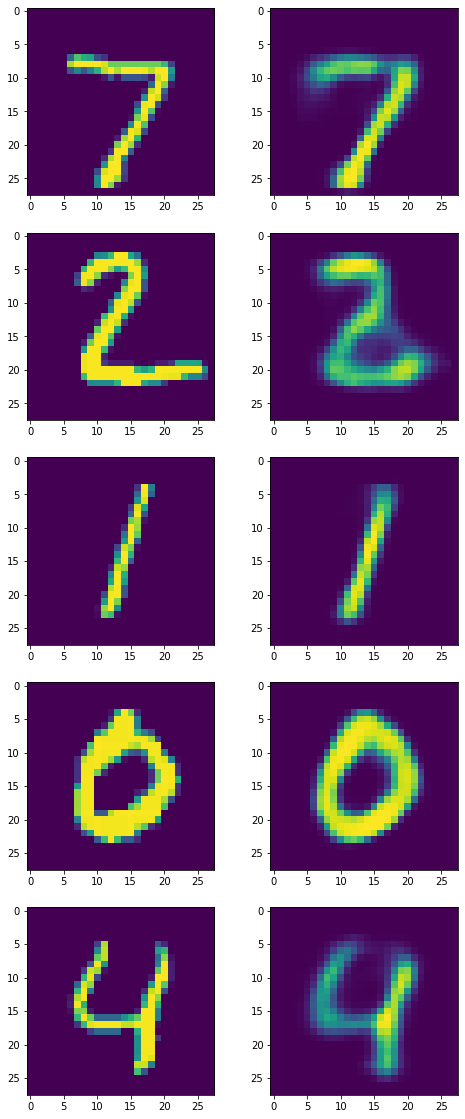

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

In [ ]:
z = np.array([np.random.normal(0, 1, 16) for i in range(10)])
output = autoencoder.sample(torch.FloatTensor(z).to(device))

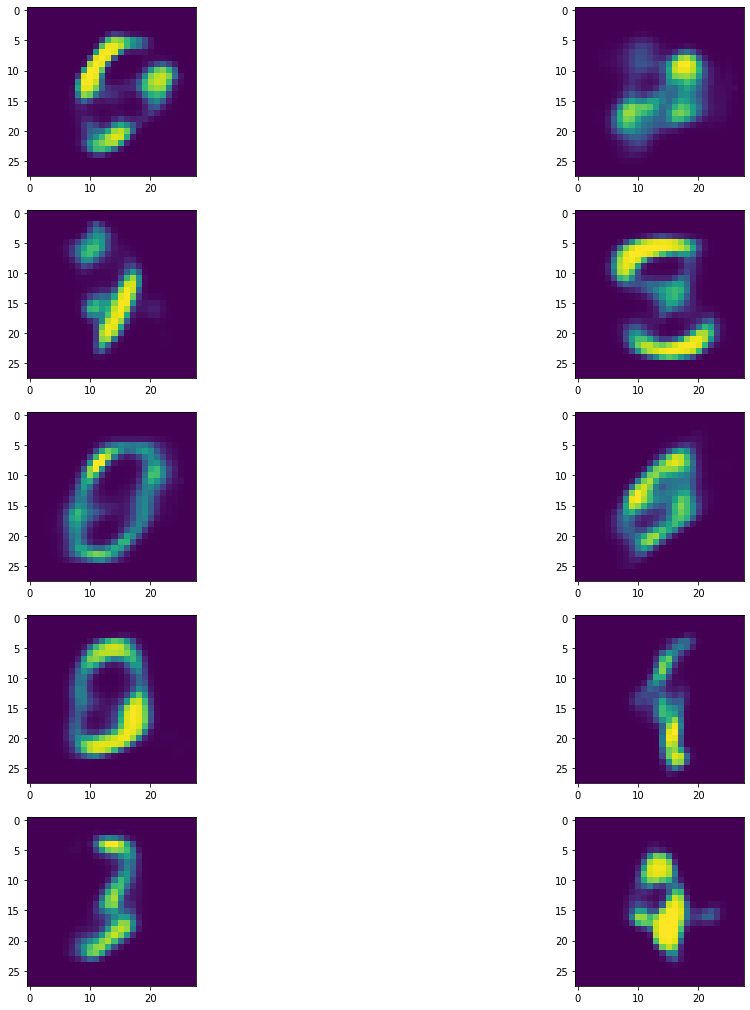

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()